In [ ]:
#https://towardsdatascience.com/gps-trajectory-clustering-with-python-9b0d35660156
#https://taginfo.openstreetmap.org/tags/type=public_transport#overview

# distancias points

In [ ]:
# PARA OCONVERTIR RECORRIDOS GEOMS EN GRAPHS
#https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils_graph.graph_from_gdfs

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import osmnx as ox 
from shapely.geometry import LineString
import geopandas as gpd
from osmnx import downloader,utils_geo,graph
import pickle
import networkx as nx
from osmnx._errors import EmptyOverpassResponse
import osmnx as ox
from osmnx import utils_graph, distance, downloader,graph
import matplotlib.pyplot as plt

In [2]:
# del original _create_graph
def create_branch_graph(response_json_branch, retain_all=False, bidirectional=True):
    """
    Create a networkx MultiDiGraph from Overpass API responses.
    Adds length attributes in meters (great-circle distance between endpoints)
    to all of the graph's (pre-simplified, straight-line) edges via the
    `distance.add_edge_lengths` function.
    Parameters
    ----------
    response_json_branch : dict
        dicts of JSON response for a route branch from the Overpass API
    retain_all : bool
        if True, return the entire graph even if it is not connected.
        otherwise, retain only the largest weakly connected component.
    bidirectional : bool
        if True, create bi-directional edges for one-way streets
    Returns
    -------
    G : networkx.MultiDiGraph
    """
    print("Creating graph from downloaded OSM data...")

    # create the graph as a MultiDiGraph and set its meta-attributes
    metadata = {
        "created_date": ox.utils.ts(),
        "crs": "epsg:4326",
        "line_name": response_json_branch['tags']['name'],
        "headway":response_json_branch['tags']['to']
    }
    G = nx.MultiDiGraph(**metadata)

    # query nodes and ways to get xy coords
    nodes = {}
    paths = {}
    nodes_temp, paths_temp = query_branch_nodes_paths(response_json_branch)
    nodes.update(nodes_temp)
    paths.update(paths_temp)

    # add each osm node to the graph
    for node, data in nodes.items():
        G.add_node(node, **data)

    # add each osm way (ie, a path of edges) to the graph
    graph._add_paths(G, paths.values(), bidirectional)

    # retain only the largest connected component if retain_all is False
    if not retain_all:
        G = utils_graph.get_largest_component(G)

    print(f"Created graph with {len(G)} nodes and {len(G.edges)} edges")

    # add length (great-circle distance between nodes) attribute to each edge
    if len(G.edges) > 0:
        G = distance.add_edge_lengths(G)

    return G
    
def query_branch_nodes_paths(response_json_branch):
    """
    Create a set of nodes and paths belonging to a relation in Osmnx schema
    (the one _parse_nodes_paths outpus) from Overpass API responses.  
    Parameters
    ----------
    response_json_branch : dict
        dicts of JSON response for a route branch from the Overpass API
    Returns
    -------
    nodes, paths : tuple of dicts
        dicts' keys = osmid and values = dict of attributes
    """ 

    overpass_settings = downloader._make_overpass_settings()

    # get path ids
    path_ids = [m['ref'] if m['type']=='way'else None for m in response_json_branch['members']]
    path_ids = list(filter(lambda item: item is not None, path_ids))
    path_ids = ','.join(map(str,path_ids))

    query_str = f"{overpass_settings};(way(id:{path_ids});>;);out;"
    response_json = downloader.overpass_request(data={"data": query_str})

    nodes, paths = graph._parse_nodes_paths(response_json)
    return nodes, paths

def query_public_transport_box(north,south,east,west):
    """
    Queries OSMN public transportation relations
    from a boungind box
    
    Parameters
    ----------
    north : float
        northern latitude of bounding box
    south : float
        southern latitude of bounding box
    east : float
        eastern longitude of bounding box
    west : float
        western longitude of bounding box

    Returns
    -------
    nodes, paths : tuple of dicts
        dicts' keys = osmid and values = dict of attributes
    """ 

    bbox = (str(south) + "," +
            str(west) + "," +
            str(north) + "," +
            str(east))
    
    tags = '["public_transport:version" = "2"]'

    query_str = """
        [out:json];
        (
        relation%s(%s);
        relation[type=route_master](br.routes);
        way(r.routes);
        node(w);
        ( .routes;.masters;._; );
        );out body;""" % (tags, bbox)
    response_json_branches = ox.downloader.overpass_request(data={'data':query_str})
        # make sure we got data back from the server request(s)
    if not 'elements' in response_json_branches:  # pragma: no cover
        raise EmptyOverpassResponse("There are no data elements in the response JSON")
    else:
        response_json_branches = response_json_branches['elements']
    return response_json_branches

def get_node_order(element):
    "gets a element from a response_json_branch member and returns node id"
    if element['type'] == 'node':
        return element['ref']
    
def get_way_order(element):
    "gets a element from a response_json_branch member and returns way id"
    if element['type'] == 'way':
        return element['ref']

In [3]:
# http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000
# carabobo y rivadavia
s,w,n,e =  -34.628335,-58.460591,-34.624062,-58.450291 

# linea 47
s,w,n,e = -34.626048,-58.530478,-34.621903,-58.520179 

# linea 32
s,w,n,e = -34.624715,-58.410423,-34.607621,-58.369224 

In [4]:
route_path = '/home/pipe/proyectos/osmnx_bus/routes_data/'

In [5]:
# query public transportation relations
response_json_branches = query_public_transport_box(s,w,n,e)

In [6]:
routes_of_interest = []
route_interest_name = 'Línea 39'
for i in response_json_branches:
    try:
        if route_interest_name in i['tags']['name']:
            print(i['tags']['name'])
            routes_of_interest.append(i)
    except:
        print('ERROR')
        print(i['tags'])
response_json_branches = routes_of_interest

Línea 39 - Ramal 1: Barracas → Palermo Viejo → Chacarita
Línea 39 - Ramal 1: Chacarita → Palermo Viejo → Barracas
Línea 39 - Ramal 2: Barracas → El Dorrego → Chacarita
Línea 39 - Ramal 2: Chacarita → El Dorrego → Barracas
Línea 39 - Ramal 3: Barracas → Plaza Serrano → Chacarita
Línea 39 - Ramal 3: Chacarita → Plaza Serrano → Barracas
ERROR
{'public_transport': 'stop_area', 'public_transport:version': '2', 'type': 'public_transport'}


In [7]:
for i in response_json_branches:
    print(len(i))

4
4
4
4
4
4


In [8]:
G_list = [create_branch_graph(relation) for relation in response_json_branches]

Creating graph from downloaded OSM data...
Created graph with 582 nodes and 1162 edges
Creating graph from downloaded OSM data...
Created graph with 508 nodes and 1014 edges
Creating graph from downloaded OSM data...
Created graph with 594 nodes and 1186 edges
Creating graph from downloaded OSM data...
Created graph with 524 nodes and 1046 edges
Creating graph from downloaded OSM data...
Created graph with 495 nodes and 988 edges
Creating graph from downloaded OSM data...
Created graph with 473 nodes and 944 edges


In [9]:
type(G_list[0])

networkx.classes.multidigraph.MultiDiGraph

In [18]:
# punto donde me conviene tomar el ramal 2 en dorrego y cramer
punto_r2 = (-34.578468, -58.440002)
# punto donde me conviene tomar el ramal 3 en ravignani y corodba
punto_r3 = (-34.585617, -58.443535)
d = (-34.625907, -58.375140)

In [19]:
relation = response_json_branches[0]
G0 = create_branch_graph(relation)
G0=G0.to_undirected()

relation = response_json_branches[2]
G2 = create_branch_graph(relation)
G2=G2.to_undirected()


relation = response_json_branches[4]
G4 = create_branch_graph(relation)
G4=G4.to_undirected()


Creating graph from downloaded OSM data...
Created graph with 582 nodes and 1162 edges
Creating graph from downloaded OSM data...
Created graph with 594 nodes and 1186 edges
Creating graph from downloaded OSM data...
Created graph with 495 nodes and 988 edges


In [20]:
_,gdf_w0 = ox.graph_to_gdfs(G0) #blue ramal 1
_,gdf_w2 = ox.graph_to_gdfs(G2) #red ramal 2
_,gdf_w4 = ox.graph_to_gdfs(G4) #black ramal 3


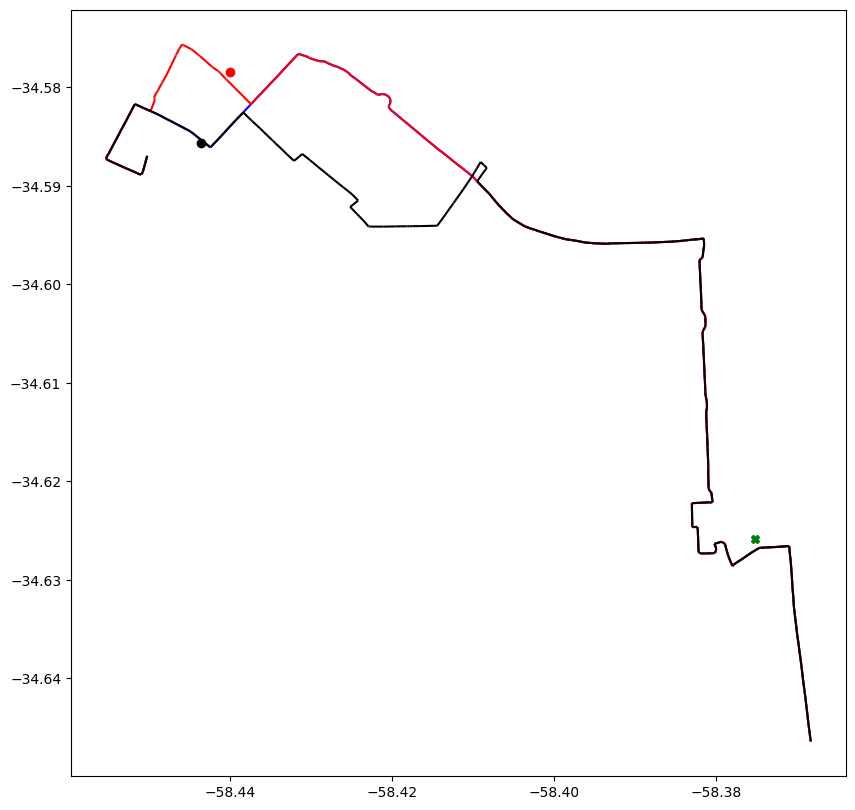

In [21]:
f,ax = plt.subplots(figsize=(10,10))
gdf_w0.plot(ax=ax, color ='blue')
gdf_w2.plot(ax=ax, color ='red')
gdf_w4.plot(ax=ax, color ='black')
ax.plot(punto_r2[1],punto_r2[0],'ro')
ax.plot(punto_r3[1],punto_r3[0],'ko')
ax.plot(d[1],d[0],'gX')

In [22]:
Gcompose = nx.compose_all([G2,G4])
_,gdf_c = ox.graph_to_gdfs(Gcompose) #blue ramal 1
Gcompose=Gcompose.to_undirected()


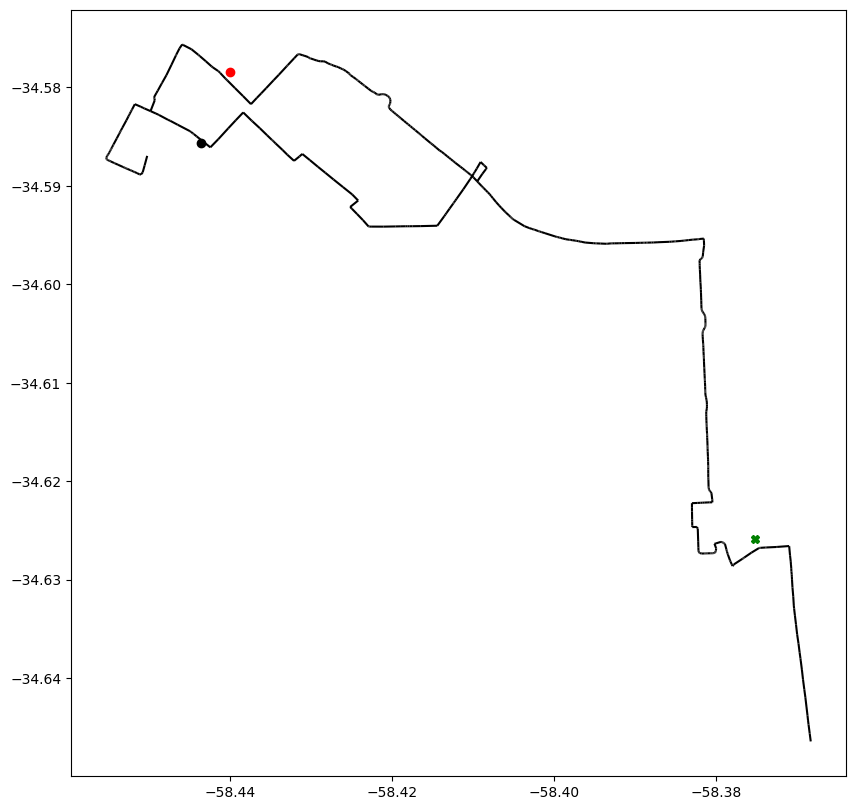

In [23]:
f,ax = plt.subplots(figsize=(10,10))
gdf_c.plot(ax=ax, color ='black')
ax.plot(punto_r2[1],punto_r2[0],'ro')
ax.plot(punto_r3[1],punto_r3[0],'ko')
ax.plot(d[1],d[0],'gX')

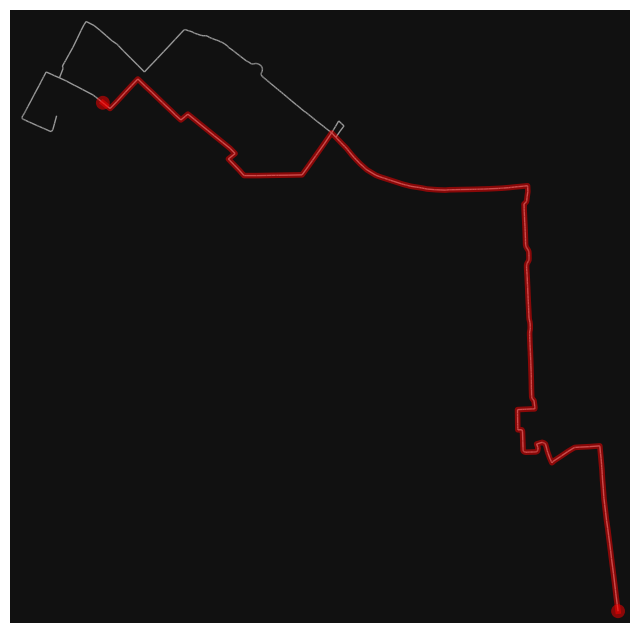

14638

In [25]:
o_y,o_x= punto_r3
d_y,d_x= d

orig = ox.distance.nearest_nodes(Gcompose, X=o_x, Y=o_y)
dest = ox.distance.nearest_nodes(Gcompose, X=d_x, Y=d_x)  

# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(Gcompose, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(Gcompose, route, node_size=0)

# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(Gcompose, route, "length")
round(sum(edge_lengths))

In [ ]:
route_osmid_list = []
route_name_list = []

for relation in response_json_branches:
    print(relation['tags']['name'])

    osmid = relation['id']
    route_name = relation['tags']['name']
    route_osmid_list.append(osmid)
    route_name_list.append(route_name)
    
    
    # get order for nodes and ways
    nodes = list(filter(lambda item: item is not None, map(get_node_order,relation['members'])))
    node_order = pd.Series(range(len(nodes)),index=nodes)

    ways = list(filter(lambda item: item is not None, map(get_way_order,relation['members'])))
    way_order = pd.DataFrame({'osmid':ways, 'order':range(len(ways))})

    # create graph
    G = create_branch_graph(relation)

    #greate gdf
    gdf_n,gdf_w = ox.graph_to_gdfs(G)

    # add order
    gdf_n['order'] = node_order
    gdf_w = gdf_w.merge(way_order, on = ['osmid'], how ='left')

    # save data

    filename = f"{osmid}"
    gdf_w.to_file(os.path.join(route_path,f'{filename}.gpkg'), driver='GPKG', layer='ways')  
    gdf_n.to_file(os.path.join(route_path,f'{filename}.gpkg'), driver='GPKG', layer='nodes')
    
    nx.write_graphml_lxml(G, os.path.join(route_path,f"{filename}.graphml"))


In [ ]:
o_y,o_x= -34.591003, -58.391161
d_y,d_x= -34.627839, -58.477069 

o_y,o_x= -34.667104,-58.492852
d_y,d_x= -34.607069,-58.488142 

orig = ox.distance.nearest_nodes(G, X=o_x, Y=o_y)
dest = ox.distance.nearest_nodes(G, X=d_x, Y=d_x)  

# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
round(sum(edge_lengths))
